In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
helper = imp.load_source('helpfunction','/home/tmettler/Desktop/uBoone/do_plots/helpfunction.py')
globale = imp.load_source('globale','/home/tmettler/Desktop/uBoone/do_plots/globale.py')
#import /home/tmettler/Desktop/uBoone/do_plots/helpfunction as helper
import collections
NuCC = imp.load_source('NuCC_function','/home/tmettler/Desktop/uBoone/do_plots/NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function','/home/tmettler/Desktop/uBoone/do_plots/NuCCWeight_function.py')

Welcome to JupyROOT 6.10/08


In [2]:
#!jupyter nbconvert --to script numuCCana_muon_cut_weight.ipynb

In [3]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRTinBNB tagger, Overlay or MC

In [4]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'muon_cut/' 
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)

#filename_overlay = 'NuCCana_Overlay_V18_V4.root'
filename_overlay = 'NuCCana_overlay_V26_weight.root'
#filename_overlay = 'NuCCana_overlay_v25_weighted_all.root'
filename_data = 'NuCCana_data_V25.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [5]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)
#V25 files
pot_data =    7.644e+18  # best with tor875
data_trigger = 1838700.0 #2220362.0 #1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	989745
Data: Number of Entries:	28005
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		7.644e+18
Ext:		0
Overlay:	1.24025430537e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0967862715198
Overlay:	0.00616325213863
Dirt:		0.0611423668132


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [6]:
if 1:
    filename_overlay = filename_overlay+'out4.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out4.root'
    filename_ext = filename_ext+'out4.root'
    filename_dirt = filename_dirt+'out4.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	989714
Data: Number of Entries:	28004
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40800



In [7]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = ['numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other']

In [8]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')

#num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [9]:
# Define signals as Marcos MCC8 analysis

'''fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue'''

'''numu_signal_cont = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5 && !track_end_uncontained' # numu CC signal definition
numu_signal_uncont = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5 && track_end_uncontained' # numu CC signal definition

numu_nc_other = 'fidVol && MCfidVol && MCNu_CCNC==1 && MCTrackPDG!=211 && MCTrackPDG!=2212' # nutral current
numu_nc_pion = 'fidVol && MCfidVol && MCNu_CCNC==1 && MCTrackPDG==211' # nutral current
numu_nc_proton = 'fidVol && MCfidVol && MCNu_CCNC==1 && MCTrackPDG==2212' # nutral current

numu_cosmic_cont = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5 && !track_end_uncontained' #low purity
numu_cosmic_uncont = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5 && track_end_uncontained' #low purity

numu_ov_cont = 'fidVol && !MCfidVol && !track_end_uncontained' # out of fiducial
numu_ov_uncont = 'fidVol && !MCfidVol && track_end_uncontained' # out of fiducial

numu_nue = 'fidVol && MCfidVol && MCNu_CCNC==0 && abs(MCNu_PDG)!=14' # e.g anti nu or nue
numu_antinu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==-14' # e.g anti nu or nue
'''
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
'''for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]'''
    
#tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
#overlay_signals = ['numu_signal_cont','numu_signal_uncont','numu_nue','numu_antinu','numu_nc_other','numu_nc_pion',\
#                   'numu_nc_proton', 'numu_ov_cont', 'numu_ov_uncont', 'numu_cosmic_cont', 'numu_cosmic_uncont']
'''
overlay_signals = ['numu_cosmic_uncont','numu_cosmic_cont','numu_ov_uncont','numu_ov_cont','numu_nc_proton','numu_nc_pion',\
                   'numu_nc_other', 'numu_antinu', 'numu_nue', 'numu_signal_uncont', 'numu_signal_cont']

#overlay_signals = overlay_signals.reverse()
'''
#for x in sample_out:
#    x.SetAlias('muon','(track_key == key_muon)')'''
'''
for x in sample_out:
    x.SetAlias('numu_signal_cont',numu_signal_cont)
    x.SetAlias('numu_signal_uncont',numu_signal_uncont)
    x.SetAlias('numu_nc_other',numu_nc_other)
    x.SetAlias('numu_nc_pion',numu_nc_pion)
    x.SetAlias('numu_nc_proton',numu_nc_proton)
    x.SetAlias('numu_cosmic_cont',numu_cosmic_cont)
    x.SetAlias('numu_cosmic_uncont',numu_cosmic_uncont)
    x.SetAlias('numu_ov_cont',numu_ov_cont)
    x.SetAlias('numu_ov_uncont',numu_ov_uncont)
    x.SetAlias('numu_nue',numu_nue)
    x.SetAlias('numu_antinu',numu_antinu)'''

"\nfor x in sample_out:\n    x.SetAlias('numu_signal_cont',numu_signal_cont)\n    x.SetAlias('numu_signal_uncont',numu_signal_uncont)\n    x.SetAlias('numu_nc_other',numu_nc_other)\n    x.SetAlias('numu_nc_pion',numu_nc_pion)\n    x.SetAlias('numu_nc_proton',numu_nc_proton)\n    x.SetAlias('numu_cosmic_cont',numu_cosmic_cont)\n    x.SetAlias('numu_cosmic_uncont',numu_cosmic_uncont)\n    x.SetAlias('numu_ov_cont',numu_ov_cont)\n    x.SetAlias('numu_ov_uncont',numu_ov_uncont)\n    x.SetAlias('numu_nue',numu_nue)\n    x.SetAlias('numu_antinu',numu_antinu)"

In [10]:
# Load the global variables for access of functions
NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root,outputdir_pdf)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [11]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

In [12]:
'''track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))' '''

track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-4)<0.9 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-4)<0.9 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.95)<0.9 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [13]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/25.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/25.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/20.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [14]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_rate_binned_mcc8'
side_right = 'right'
side_left = 'left'
start = time.time()
#NuCC_w.make_stacked_histo_weight_MCC8(cut,'cos(TrackTheta)','EventWeight','cos(Theta)',-10,270,40,'CosTheta'+name,side_left)
end = time.time()
print(end - start)

5.22136688232e-05


In [15]:
name = '_rate_binned'
start = time.time()
#NuCC_w.make_stacked_histo_weightV2(cut,'cos(TrackTheta)','EventWeight','cos(Theta)',-10,270,40,'CosTheta'+name,side_left)
end = time.time()
print(end - start)

0.000141859054565


In [15]:
cut = 'fidVol && muon'
name = '_initial_V'
side_right = 'right'
side_left = 'left'
start = time.time()
#NuCC_w.make_stacked_histo_weight_MCC8_V(cut,'Nu_Vx_sce','EventWeight','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_left)
end = time.time()
print(end - start)
#NuCC_w.make_stacked_histo_weight_MCC8_V(cut,'Nu_Vy_sce','EventWeight','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_left)
end = time.time()
print(end - start)
#NuCC_w.make_stacked_histo_weight_MCC8_V(cut,'Nu_Vz_sce','EventWeight','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_left)
end = time.time()
print(end - start)

2.90870666504e-05
0.000487089157104
0.000585079193115


In [16]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_muon_cut_V'
side_right = 'right'
side_left = 'left'
start = time.time()
#NuCC_w.make_stacked_histo_weight_MCC8_V(cut,'Nu_Vx_sce','EventWeight','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_left)
end = time.time()
print(end - start)
#NuCC_w.make_stacked_histo_weight_MCC8_V(cut,'Nu_Vy_sce','EventWeight','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_left)
end = time.time()
print(end - start)
#NuCC_w.make_stacked_histo_weight_MCC8_V(cut,'Nu_Vz_sce','EventWeight','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_left)
end = time.time()
print(end - start)

2.69412994385e-05
0.00122308731079
0.00172114372253


In [17]:
cut = 'fidVol && muon'
name = '_initial'
side_right = 'right'
side_left = 'left'
'''start = time.time()
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && TrackTheta!=-9','cos(TrackTheta)','EventWeight','cos(theta)',-1,1,20,'costhetaw'+name,side_left)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && TrackTheta!=-9','TrackPhi','EventWeight','Track Phi',-3.141,3.141,20,'phi'+name,side_left)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','TrackMomMCS_mom','EventWeight','TrackMomMCS_mom',0,1.5,20,'TrackMomMCS_mom'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vx_sce','EventWeight','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vy_sce','EventWeight','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vz_sce','EventWeight','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_right)
end = time.time()
print(end - start)'''

"start = time.time()\nNuCC_w.make_stacked_histo_weight_MCC8(cut + ' && TrackTheta!=-9','cos(TrackTheta)','EventWeight','cos(theta)',-1,1,20,'costhetaw'+name,side_left)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut + ' && TrackTheta!=-9','TrackPhi','EventWeight','Track Phi',-3.141,3.141,20,'phi'+name,side_left)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','TrackMomMCS_mom','EventWeight','TrackMomMCS_mom',0,1.5,20,'TrackMomMCS_mom'+name,side_right)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vx_sce','EventWeight','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vy_sce','EventWeight','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_right)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vz_sce','EventWei

In [18]:
'''cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_muon_cut'
start = time.time()
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && TrackTheta!=-9','cos(TrackTheta)','EventWeight','cos(theta)',-1,1,20,'costhetaw'+name,side_left)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && TrackTheta!=-9','TrackPhi','EventWeight','Track Phi',-3.141,3.141,20,'phi'+name,side_left)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','TrackMomMCS_mom','EventWeight','TrackMomMCS_mom',0,1.5,20,'TrackMomMCS_mom'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vx_sce','EventWeight','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vy_sce','EventWeight','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vz_sce','EventWeight','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_right)
end = time.time()
print(end - start)'''

"cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'\nname = '_muon_cut'\nstart = time.time()\nNuCC_w.make_stacked_histo_weight_MCC8(cut + ' && TrackTheta!=-9','cos(TrackTheta)','EventWeight','cos(theta)',-1,1,20,'costhetaw'+name,side_left)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut + ' && TrackTheta!=-9','TrackPhi','EventWeight','Track Phi',-3.141,3.141,20,'phi'+name,side_left)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','TrackMomMCS_mom','EventWeight','TrackMomMCS_mom',0,1.5,20,'TrackMomMCS_mom'+name,side_right)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vx_sce','EventWeight','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vy_sce','EventWeight','Reco. Nu 

In [19]:
'''cut = 'fidVol && muon'
name = '_initial'
side_right = 'right'
side_left = 'left'
start = time.time()
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','NuTracks','EventWeight','Number of Tracks',0,10,10,'NuTracks'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','NumPfp','EventWeight','Number of Pfparticle',0,10,10,'NumPfp'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','TrackLength','EventWeight','Track Length',0,700,20,'TrackLength'+name,side_right)
end = time.time()'''

"cut = 'fidVol && muon'\nname = '_initial'\nside_right = 'right'\nside_left = 'left'\nstart = time.time()\nNuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','NuTracks','EventWeight','Number of Tracks',0,10,10,'NuTracks'+name,side_right)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','NumPfp','EventWeight','Number of Pfparticle',0,10,10,'NumPfp'+name,side_right)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','TrackLength','EventWeight','Track Length',0,700,20,'TrackLength'+name,side_right)\nend = time.time()"

In [20]:
'''cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_muon_cut'
side_right = 'right'
side_left = 'left'
start = time.time()
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','NuTracks','EventWeight','Number of Tracks',0,10,10,'NuTracks'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','NumPfp','EventWeight','Number of Pfparticle',0,10,10,'NumPfp'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','TrackLength','EventWeight','Track Length',0,700,20,'TrackLength'+name,side_right)
end = time.time()'''

"cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'\nname = '_muon_cut'\nside_right = 'right'\nside_left = 'left'\nstart = time.time()\nNuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','NuTracks','EventWeight','Number of Tracks',0,10,10,'NuTracks'+name,side_right)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','NumPfp','EventWeight','Number of Pfparticle',0,10,10,'NumPfp'+name,side_right)\nend = time.time()\nprint(end - start)\nNuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','TrackLength','EventWeight','Track Length',0,700,20,'TrackLength'+name,side_right)\nend = time.time()"

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Histograms are filled with weights
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/png/h_eff_particle_multi.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/root/h_eff_particle_multi.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/pdf/h_eff_particle_multi.pdf has been created


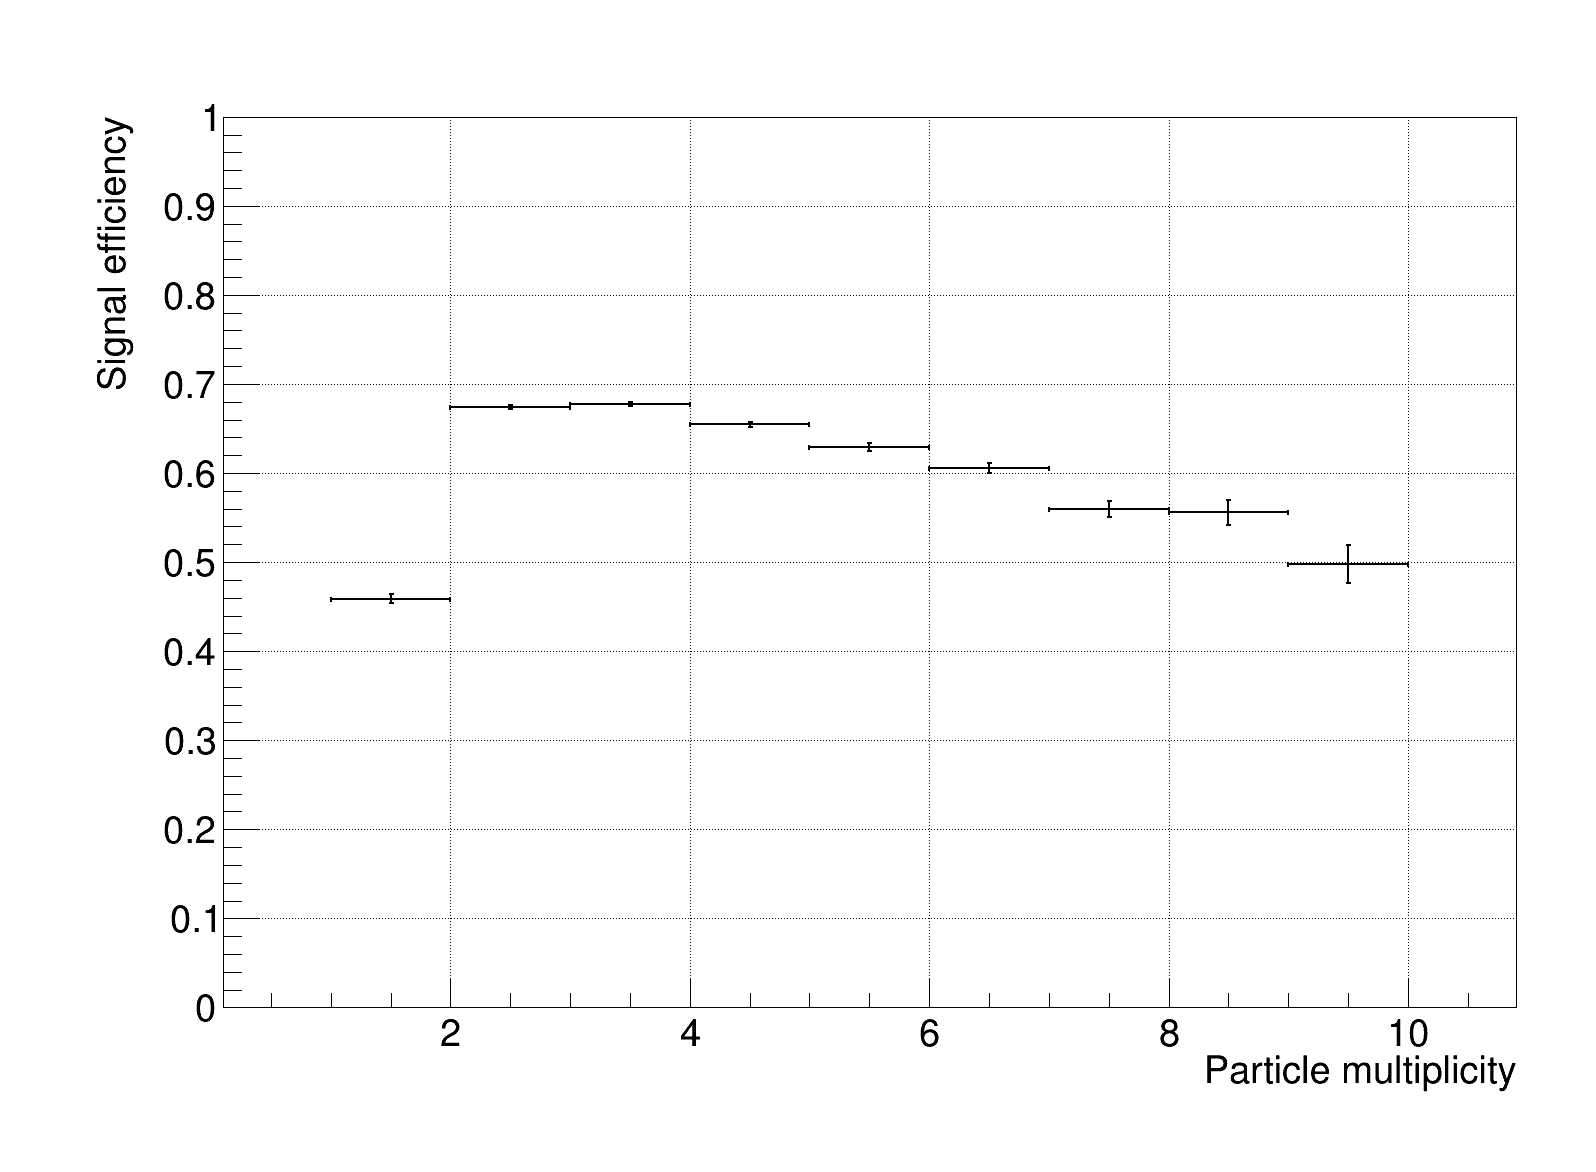

In [21]:

mom_bins = [ 0.00, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0 ]
binnum = len(mom_bins) - 1
weight_name = 'EventWeight*TunedCentralValue_Genie'
title = 'Particle multi'

h_1d = ROOT.TH1F('h_1d',"Particle multi",binnum,array('f',mom_bins))
h_1d_true = ROOT.TH1F('h_1d_true',"Particle multi true",binnum,array('f',mom_bins))

variable = 'NumPfp'
cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'

overlay_out.Draw(variable+'>>h_1d',weight_name+'*('+cut+'&& numu_signal)')
overlay_out.Draw(variable+'>>h_1d_true',weight_name+'*(numu_true)')
eff =  ROOT.TEfficiency(h_1d,h_1d_true)
eff.SetStatisticOption(ROOT.TEfficiency.kFCP)#;  // to set option for errors (see ref doc)
eff.SetConfidenceLevel(0.68)
eff.SetTitle(title)
eff.Draw("AP")
ROOT.gPad.Update()
graph = eff.GetPaintedGraph()
graph.SetMinimum(0)
graph.SetMaximum(1)
graph.SetLineWidth(2)
graph.GetXaxis().SetTitle("Particle multiplicity")
graph.GetYaxis().SetTitle("Signal efficiency")
graph.Draw("AP")
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_eff_particle_multi.png")
c1.SaveAs(globale.outputdir_root + "h_eff_particle_multi.root")
c1.SaveAs(globale.outputdir_pdf + "h_eff_particle_multi.pdf")



Warning in <TROOT::Append>: Replacing existing TH1: h_1d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_1d_true (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Histograms are filled with weights
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/png/h_eff_track_multi.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/root/h_eff_track_multi.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/pdf/h_eff_track_multi.pdf has been created


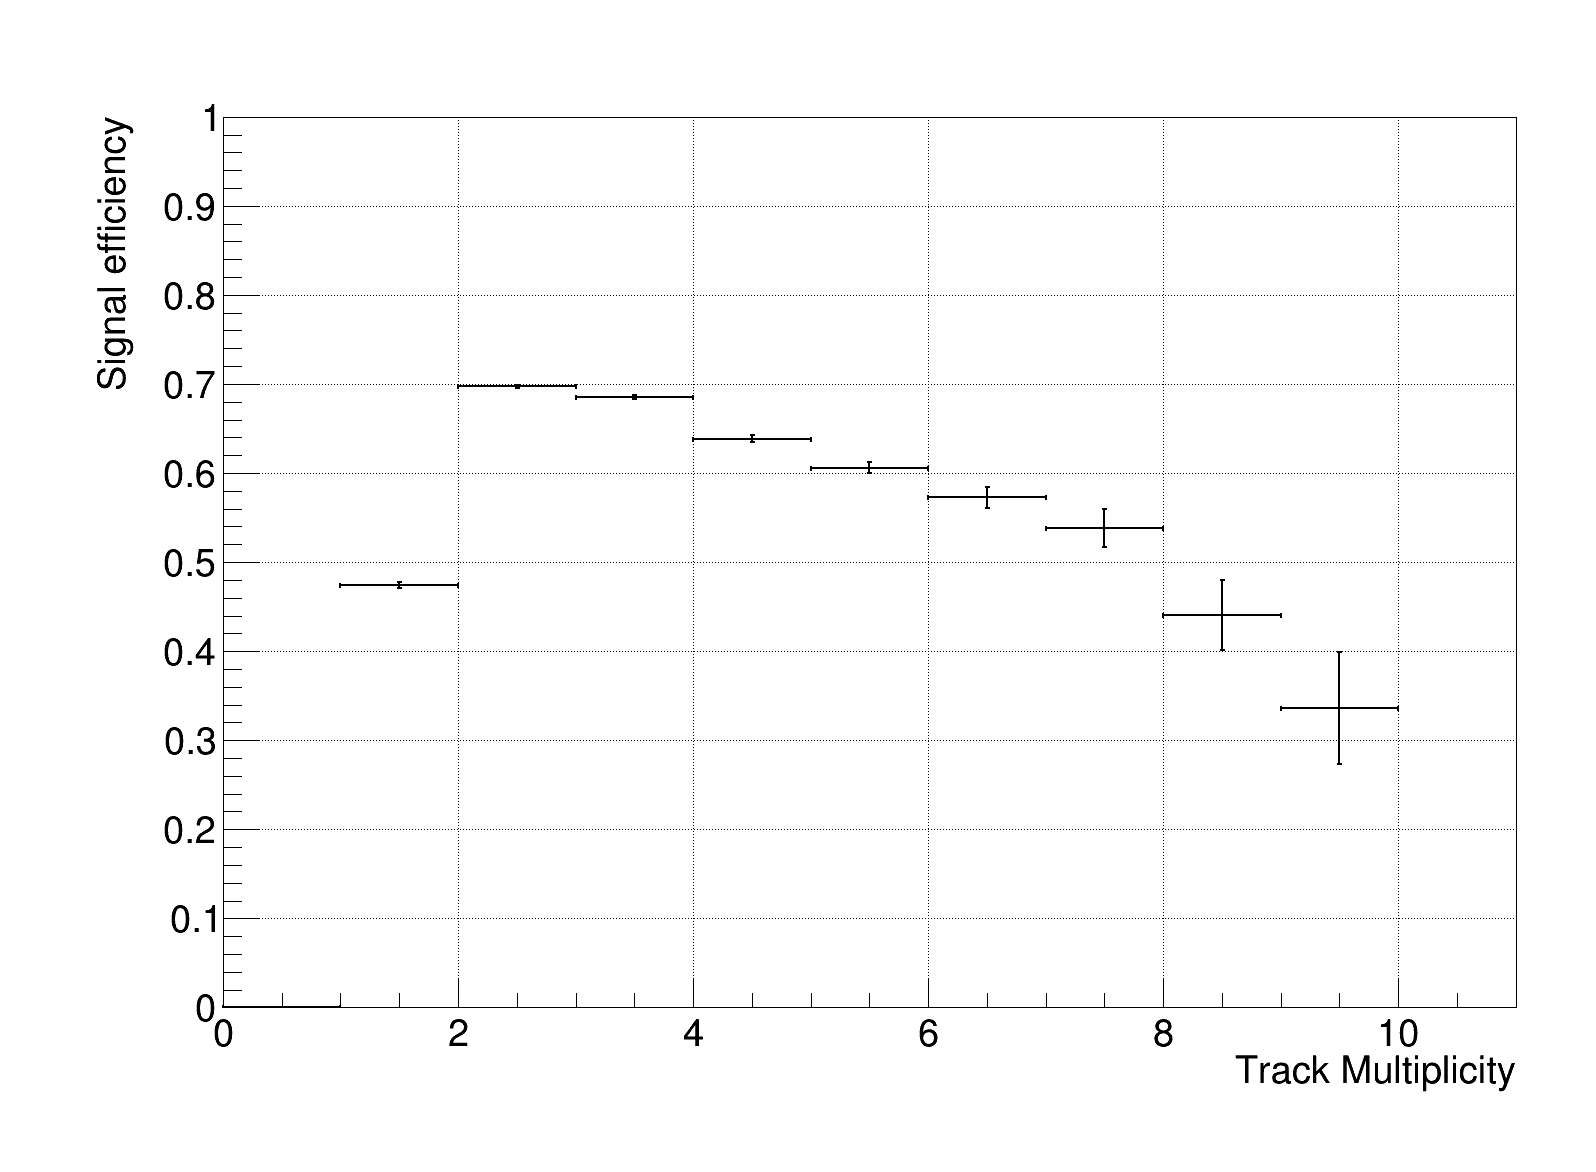

In [22]:
mom_bins = [ 0.00, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0 ]
binnum = len(mom_bins) - 1

h_1d = ROOT.TH1F('h_1d',"Particle multi",binnum,array('f',mom_bins))
h_1d_true = ROOT.TH1F('h_1d_true',"Particle multi true",binnum,array('f',mom_bins))

variable = 'NuTracks'
cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'

overlay_out.Draw(variable+'>>h_1d',weight_name+'*('+cut+'&& numu_signal)')
overlay_out.Draw(variable+'>>h_1d_true',weight_name+'*(numu_true)')
eff =  ROOT.TEfficiency(h_1d,h_1d_true)
eff.SetStatisticOption(ROOT.TEfficiency.kFCP)#;  // to set option for errors (see ref doc)
eff.SetConfidenceLevel(0.68)
eff.SetTitle(title)
eff.Draw("AP")
ROOT.gPad.Update()
graph = eff.GetPaintedGraph()
graph.SetMinimum(0)
graph.SetMaximum(1)
graph.SetLineWidth(2)
graph.GetXaxis().SetTitle("Track Multiplicity")
graph.GetYaxis().SetTitle("Signal efficiency")
graph.Draw("AP")
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_eff_track_multi.png")
c1.SaveAs(globale.outputdir_root + "h_eff_track_multi.root")
c1.SaveAs(globale.outputdir_pdf + "h_eff_track_multi.pdf")



Warning in <TROOT::Append>: Replacing existing TH1: h_1d (Potential memory leak).


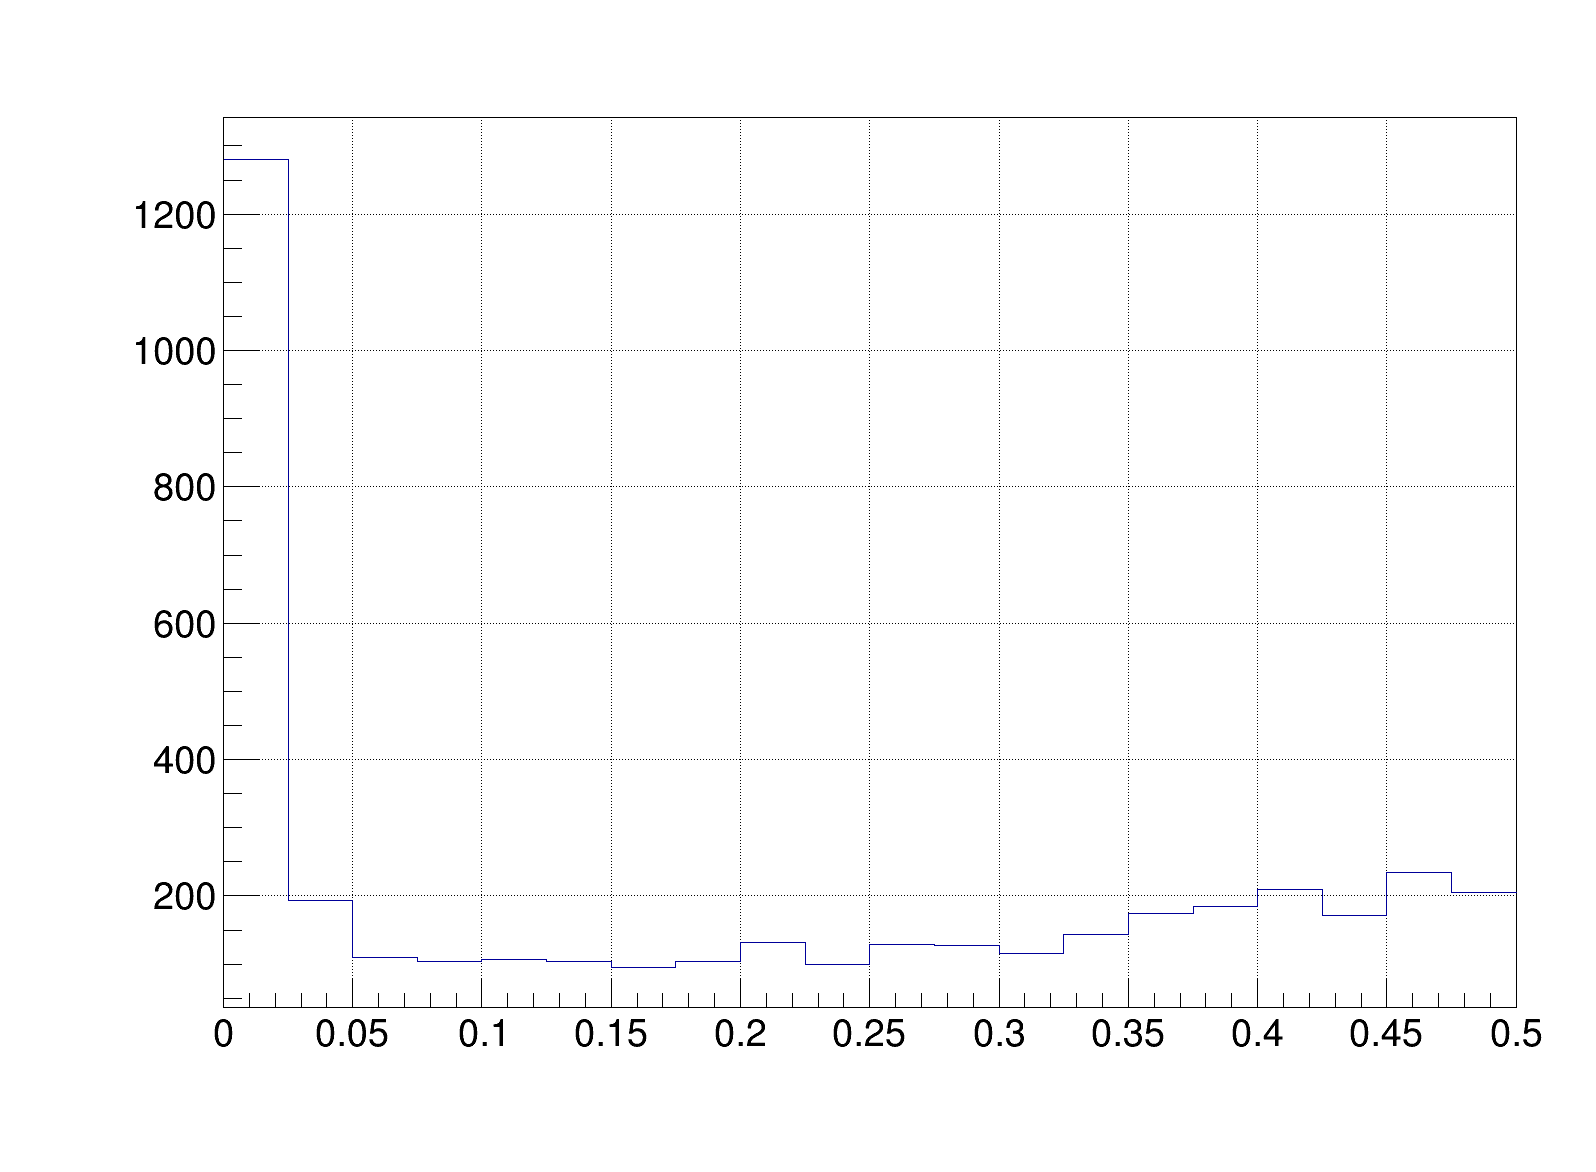

In [23]:
h_1d = ROOT.TH1F('h_1d',"Particle multi",20,0,0.5)
overlay_out.Draw('MCTrackPurity>>h_1d','numu_lowpur && '+cut)
c1.Draw()

In [25]:
NuCC_w.printEff_w('fidVol && muon')

Efficiency for cut:  fidVol && muon
Used weight:  EventWeight*TunedCentralValue_Genie

Keep of     ext:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	-0.00%
Keep of overlay:	100.00%	 reject:	0.00%

Efficiency:		66.60%
Purity:			34.39%
Purity*Efficiency	22.91

Amount of     ext:	38.98%
Amount of    dirt:	4.82%
Amount of overlay:	56.21%

Signal definition=  numu_signal: 34.39%
Signal definition=    numu_nomu: 2.60%
Signal definition=  numu_lowpur: 3.49%
Signal definition=      numu_nc: 6.23%
Signal definition=      numu_ov: 8.97%
Signal definition=   numu_other: 0.53%


(66.60419570575043, 34.38973738185618)

Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [26]:
NuCC_w.printEff_w('fidVol && muon && nr_crthit_top==0')

Efficiency for cut:  fidVol && muon && nr_crthit_top==0
Used weight:  EventWeight*TunedCentralValue_Genie

Keep of     ext:	62.31%	 reject:	37.69%
Keep of    dirt:	95.66%	 reject:	4.34%
Keep of overlay:	96.97%	 reject:	3.03%

Efficiency:		64.70%
Purity:			40.06%
Purity*Efficiency	25.92

Amount of     ext:	29.12%
Amount of    dirt:	5.53%
Amount of overlay:	65.36%

Signal definition=  numu_signal: 40.06%
Signal definition=    numu_nomu: 2.98%
Signal definition=  numu_lowpur: 4.01%
Signal definition=      numu_nc: 7.32%
Signal definition=      numu_ov: 10.36%
Signal definition=   numu_other: 0.63%


(64.70349277198066, 40.059211343872285)

Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [27]:
NuCC_w.printEff_w('fidVol && muon && nr_crthit_top==0 && crthit_vertex_zcut==0')

Efficiency for cut:  fidVol && muon && nr_crthit_top==0 && crthit_vertex_zcut==0
Used weight:  EventWeight*TunedCentralValue_Genie

Keep of     ext:	50.15%	 reject:	49.85%
Keep of    dirt:	75.01%	 reject:	24.99%
Keep of overlay:	95.25%	 reject:	4.75%

Efficiency:		64.09%
Purity:			43.16%
Purity*Efficiency	27.66

Amount of     ext:	25.49%
Amount of    dirt:	4.72%
Amount of overlay:	69.83%

Signal definition=  numu_signal: 43.16%
Signal definition=    numu_nomu: 3.16%
Signal definition=  numu_lowpur: 4.29%
Signal definition=      numu_nc: 7.90%
Signal definition=      numu_ov: 10.65%
Signal definition=   numu_other: 0.68%


(64.0932314030938, 43.160574144504615)

Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [28]:
NuCC_w.printEff_w('fidVol && muon && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0)')

Efficiency for cut:  fidVol && muon && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0)
Used weight:  EventWeight*TunedCentralValue_Genie

Keep of     ext:	44.29%	 reject:	55.71%
Keep of    dirt:	72.40%	 reject:	27.60%
Keep of overlay:	92.98%	 reject:	7.02%

Efficiency:		63.58%
Purity:			44.98%
Purity*Efficiency	28.60

Amount of     ext:	23.65%
Amount of    dirt:	4.78%
Amount of overlay:	71.61%

Signal definition=  numu_signal: 44.98%
Signal definition=    numu_nomu: 3.02%
Signal definition=  numu_lowpur: 4.30%
Signal definition=      numu_nc: 8.20%
Signal definition=      numu_ov: 10.42%
Signal definition=   numu_other: 0.70%


(63.581916562348795, 44.980234179481094)

Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [29]:
NuCC_w.printEff_w('fidVol && muon && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut')

Efficiency for cut:  fidVol && muon && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut
Used weight:  EventWeight*TunedCentralValue_Genie

Keep of     ext:	36.35%	 reject:	63.65%
Keep of    dirt:	60.27%	 reject:	39.73%
Keep of overlay:	86.52%	 reject:	13.48%

Efficiency:		61.33%
Purity:			48.22%
Purity*Efficiency	29.57

Amount of     ext:	21.57%
Amount of    dirt:	4.42%
Amount of overlay:	74.05%

Signal definition=  numu_signal: 48.22%
Signal definition=    numu_nomu: 3.26%
Signal definition=  numu_lowpur: 3.71%
Signal definition=      numu_nc: 8.47%
Signal definition=      numu_ov: 9.67%
Signal definition=   numu_other: 0.74%


(61.32910910845842, 48.21723687106882)

Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [30]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1')

Efficiency for cut:  fidVol && muon && crt_tom_cut && TrackScore>0.8                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1
Used weight:  EventWeight*TunedCentralValue_Genie

Keep of     ext:	10.20%	 reject:	89.80%
Keep of    dirt:	18.72%	 reject:	81.28%
Keep of overlay:	58.44%	 reject:	41.56%

Efficiency:		52.82%
Purity:			72.29%
Purity*Efficiency	38.18

Amount of     ext:	10.54%
Amount of    dirt:	2.39%
Amount of overlay:	87.08%

Signal definition=  numu_signal: 72.29%
Signal definition=    numu_nomu: 2.62%
Signal definition=  numu_lowpur: 2.62%
Signal definition=      numu_nc: 3.25%
Signal definition=      numu_ov: 5.53%
Signal definition=   numu_other: 0.77%


(52.818513027418426, 72.28536475282512)

Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [31]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut')

Efficiency for cut:  fidVol && muon && crt_tom_cut
Used weight:  EventWeight*TunedCentralValue_Genie

Keep of     ext:	36.35%	 reject:	63.65%
Keep of    dirt:	60.27%	 reject:	39.73%
Keep of overlay:	86.52%	 reject:	13.48%

Efficiency:		61.33%
Purity:			48.22%
Purity*Efficiency	29.57

Amount of     ext:	21.57%
Amount of    dirt:	4.42%
Amount of overlay:	74.05%

Signal definition=  numu_signal: 48.22%
Signal definition=    numu_nomu: 3.26%
Signal definition=  numu_lowpur: 3.71%
Signal definition=      numu_nc: 8.47%
Signal definition=      numu_ov: 9.67%
Signal definition=   numu_other: 0.74%


(61.32910910845842, 48.21723687106882)

Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [32]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut && TrackScore>0.8')

Efficiency for cut:  fidVol && muon && crt_tom_cut && TrackScore>0.8
Used weight:  EventWeight*TunedCentralValue_Genie

Keep of     ext:	32.42%	 reject:	67.58%
Keep of    dirt:	48.85%	 reject:	51.15%
Keep of overlay:	80.29%	 reject:	19.71%

Efficiency:		59.76%
Purity:			51.36%
Purity*Efficiency	30.69

Amount of     ext:	21.03%
Amount of    dirt:	3.92%
Amount of overlay:	75.12%

Signal definition=  numu_signal: 51.36%
Signal definition=    numu_nomu: 3.09%
Signal definition=  numu_lowpur: 3.37%
Signal definition=      numu_nc: 7.65%
Signal definition=      numu_ov: 8.93%
Signal definition=   numu_other: 0.72%


(59.76476733261892, 51.35771301030164)

Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [33]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20')

Efficiency for cut:  fidVol && muon && crt_tom_cut && TrackScore>0.8                && TrackLength>20
Used weight:  EventWeight*TunedCentralValue_Genie

Keep of     ext:	29.09%	 reject:	70.91%
Keep of    dirt:	40.60%	 reject:	59.40%
Keep of overlay:	73.47%	 reject:	26.53%

Efficiency:		58.53%
Purity:			55.38%
Purity*Efficiency	32.41

Amount of     ext:	20.78%
Amount of    dirt:	3.59%
Amount of overlay:	75.69%

Signal definition=  numu_signal: 55.38%
Signal definition=    numu_nomu: 2.72%
Signal definition=  numu_lowpur: 3.25%
Signal definition=      numu_nc: 5.40%
Signal definition=      numu_ov: 8.26%
Signal definition=   numu_other: 0.68%


(58.52595753131749, 55.38095339889561)

Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [34]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78')

Efficiency for cut:  fidVol && muon && crt_tom_cut && TrackScore>0.8                && TrackLength>20 && TrackPID_chiproton>78
Used weight:  EventWeight*TunedCentralValue_Genie

Keep of     ext:	28.03%	 reject:	71.97%
Keep of    dirt:	38.60%	 reject:	61.40%
Keep of overlay:	69.34%	 reject:	30.66%

Efficiency:		58.36%
Purity:			58.26%
Purity*Efficiency	34.00

Amount of     ext:	21.12%
Amount of    dirt:	3.60%
Amount of overlay:	75.36%

Signal definition=  numu_signal: 58.26%
Signal definition=    numu_nomu: 2.00%
Signal definition=  numu_lowpur: 3.21%
Signal definition=      numu_nc: 3.07%
Signal definition=      numu_ov: 8.18%
Signal definition=   numu_other: 0.64%


(58.360059239881714, 58.26025528024519)

Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [35]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1')

Efficiency for cut:  fidVol && muon && crt_tom_cut && TrackScore>0.8                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1
Used weight:  EventWeight*TunedCentralValue_Genie

Keep of     ext:	10.20%	 reject:	89.80%
Keep of    dirt:	18.72%	 reject:	81.28%
Keep of overlay:	58.44%	 reject:	41.56%

Efficiency:		52.82%
Purity:			72.29%
Purity*Efficiency	38.18

Amount of     ext:	10.54%
Amount of    dirt:	2.39%
Amount of overlay:	87.08%

Signal definition=  numu_signal: 72.29%
Signal definition=    numu_nomu: 2.62%
Signal definition=  numu_lowpur: 2.62%
Signal definition=      numu_nc: 3.25%
Signal definition=      numu_ov: 5.53%
Signal definition=   numu_other: 0.77%


(52.818513027418426, 72.28536475282512)

Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [36]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1')

Efficiency for cut:  fidVol && muon && crt_tom_cut && TrackScore>0.8                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1
Used weight:  EventWeight*TunedCentralValue_Genie

Keep of     ext:	10.20%	 reject:	89.80%
Keep of    dirt:	18.72%	 reject:	81.28%
Keep of overlay:	58.44%	 reject:	41.56%

Efficiency:		52.82%
Purity:			72.29%
Purity*Efficiency	38.18

Amount of     ext:	10.54%
Amount of    dirt:	2.39%
Amount of overlay:	87.08%

Signal definition=  numu_signal: 72.29%
Signal definition=    numu_nomu: 2.62%
Signal definition=  numu_lowpur: 2.62%
Signal definition=      numu_nc: 3.25%
Signal definition=      numu_ov: 5.53%
Signal definition=   numu_other: 0.77%


(52.818513027418426, 72.28536475282512)

Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).


In [ ]:
eff_cut = [69.17,67.20,66.55,66.01,63.65,62.25,61.60,61.42,55.62]
pur_cut = [33.23,39.09,42.14,43.92,47.09,50.40,55.00,57.81,72.04]
effpur_ = [22.98,26.2728.05,28.99,29.97,31.37,33.88,35.51,40.07]

eff_cut = [69.17,69.17,69.17,69.17,69.17,67.58,66.83,66.64,60.11]
pur_cut = [33.23,33.23,33.23,33.23,33.23,35.60,38.40,40.06,60.08]
effpur_ = [22.98,22.98,22.98,22.98,22.98,24.06,25.66,26.70,36.11]


Warning in <TROOT::Append>: Replacing existing TH1: h_eff_cut (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_pur_cut (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_effpur_cut (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/png/h_eff_pur_cut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/root/h_eff_pur_cut.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/pdf/h_eff_pur_cut.pdf has been created


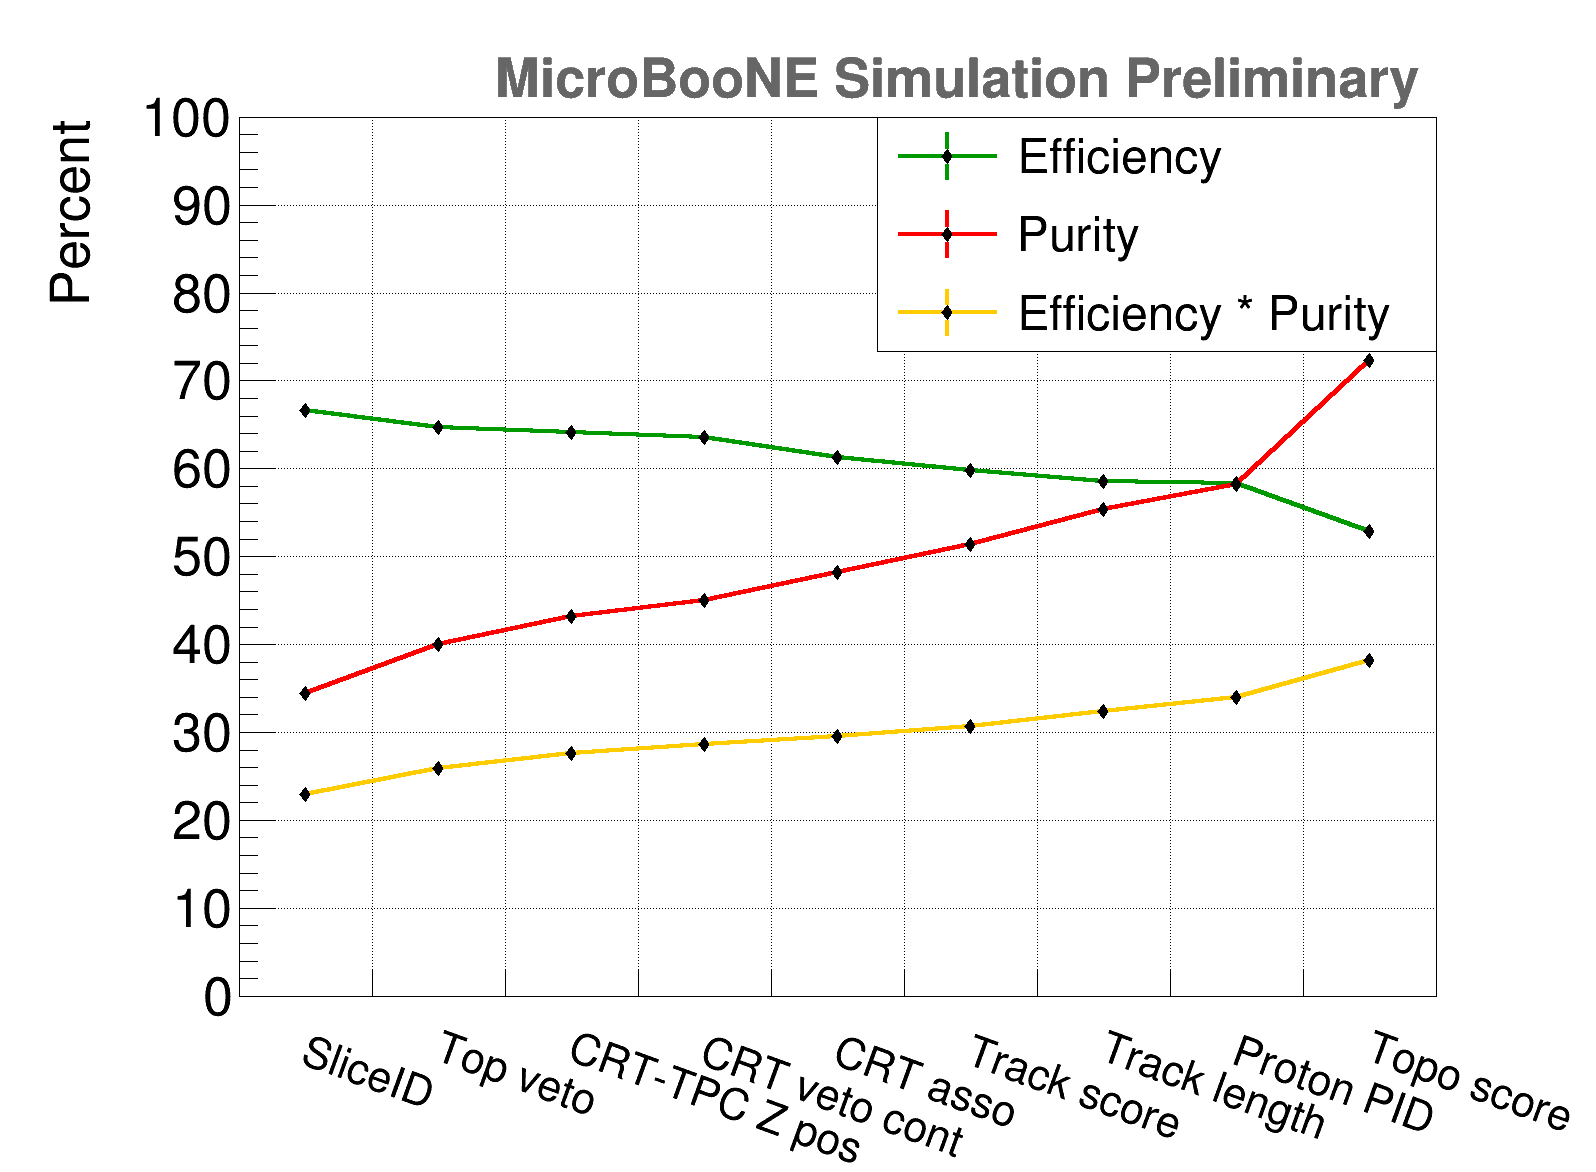

In [16]:

eff_cut = [66.60,64.70,64.09,63.58,61.33,59.76,58.53,58.36,52.82]
pur_cut = [34.39,40.06,43.16,44.98,48.22,51.36,55.38,58.26,72.29]
effpur_cut = [22.91,25.92,27.66,28.60,29.57,30.69,32.41,34.00,38.18]

h_eff_cut = ROOT.TH1F('h_eff_cut','h_eff_cut',len(eff_cut),0,len(eff_cut))
h_pur_cut = ROOT.TH1F('h_pur_cut','h_pur_cut',len(eff_cut),0,len(eff_cut))
h_effpur_cut = ROOT.TH1F('h_effpur_cut','h_effpur_cut',len(eff_cut),0,len(eff_cut))

for i in range(1,len(eff_cut)+1):
    h_eff_cut.SetBinContent(i,eff_cut[i-1])
    h_pur_cut.SetBinContent(i,pur_cut[i-1])
    h_effpur_cut.SetBinContent(i,effpur_cut[i-1])

    
    
legend = ROOT.TLegend(0.55,0.7,0.9,0.9) # LEGEND LEFT
legend.AddEntry(h_eff_cut,"Efficiency","lep");
legend.AddEntry(h_pur_cut,"Purity","lep");
legend.AddEntry(h_effpur_cut,"Efficiency * Purity","lep");

h_eff_cut.SetMinimum(0)
h_eff_cut.SetMaximum(100)

h_eff_cut.SetLineColor(ROOT.kGreen+2)
h_eff_cut.SetLineWidth(4)
h_eff_cut.SetMarkerSize(2)
h_eff_cut.SetMarkerStyle(33)

h_pur_cut.SetLineColor(ROOT.kRed)
h_pur_cut.SetLineWidth(4)
h_pur_cut.SetMarkerSize(2)
h_pur_cut.SetMarkerStyle(33)

h_effpur_cut.SetLineColor(ROOT.kOrange)
h_effpur_cut.SetLineWidth(4)
h_effpur_cut.SetMarkerSize(2)
h_effpur_cut.SetMarkerStyle(33)

h_eff_cut.GetYaxis().SetTitleSize(0.05)
h_eff_cut.GetYaxis().SetTitleOffset(0.0)
h_eff_cut.GetYaxis().SetLabelSize(0.05)

h_eff_cut.GetXaxis().SetTitleSize(0.15)
h_eff_cut.GetXaxis().SetLabelSize(0.15)
h_eff_cut.GetXaxis().SetTitleOffset(-999)
h_eff_cut.GetXaxis().SetLabelOffset(0.02)
h_eff_cut.GetXaxis().SetLabelSize(0.06)
h_eff_cut.SetYTitle("Percent")
h_eff_cut.GetXaxis().SetBinLabel(1, 'SliceID')
h_eff_cut.GetXaxis().SetBinLabel(2, 'Top veto')
h_eff_cut.GetXaxis().SetBinLabel(3, 'CRT-TPC Z pos')
h_eff_cut.GetXaxis().SetBinLabel(4, 'CRT veto cont')
h_eff_cut.GetXaxis().SetBinLabel(5, 'CRT asso')
h_eff_cut.GetXaxis().SetBinLabel(6, 'Track score')
h_eff_cut.GetXaxis().SetBinLabel(7, 'Track length')
h_eff_cut.GetXaxis().SetBinLabel(8, 'Proton PID')
h_eff_cut.GetXaxis().SetBinLabel(9, 'Topo score')
h_eff_cut.Draw('PL')
h_pur_cut.Draw('PL same')
h_effpur_cut.Draw('PL same')

legend.Draw()
#prelim, pot_tex = draw_adding()
#prelim.Draw()
#pot_tex.Draw()
prelim = draw_sim()
prelim.Draw()
c1.SetRightMargin(0.1)
c1.SetLeftMargin(0.15)
c1.SetBottomMargin(0.15)
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_pur_cut.png")
c1.SaveAs(outputdir_root + "h_eff_pur_cut.root")
c1.SaveAs(outputdir_pdf + "h_eff_pur_cut.pdf")

In [16]:
nenner = 'numu_true'
zahler = 'fidVol && muon && numu_signal'
cut = 'fidVol && muon'
start = time.time()
NuCC_w.plot_eff_w(nenner,zahler,cut,'initial','initial')
end = time.time()
print(end - start)

Efficiency:	66.30%
Purity:		34.39%
12.3624069691


Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Histograms are filled with weights
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/png/h_eff_energyinitial.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/root/h_eff_energyinitial.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/pdf/h_eff_energyinitial.pdf has been created
Warnin

In [17]:
nenner = 'numu_true'
zahler = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
start = time.time()
NuCC_w.plot_eff_w(nenner,zahler,cut,'allcut','allcut')
end = time.time()
print(end - start)

Efficiency:	52.58%
Purity:		72.29%
17.4869430065


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Histograms are filled with weights
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/png/h_eff_energyallcut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/root/h_eff_energyallcut.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35

In [18]:
nenner = 'numu_true && fidVol && muon && numu_signal'
zahler = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
start = time.time()
NuCC_w.plot_eff_w(nenner,zahler,cut,'only_cut','only_cut')
end = time.time()
print(end - start)

Efficiency:	52.58%
Purity:		72.29%
19.2168889046


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Warning in <TROOT::Append>: Replacing existing TH1: h_weight_func (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Histograms are filled with weights
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/png/h_eff_energyonly_cut.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/muon_cut/root/h_eff_energyonly_cut.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_0

In [ ]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

In [ ]:
xstart = -50
xend = 1000
xbin = 50
title = 'test'
name = 'allcut'

nenner_cut = 'numu_true'
zahler_cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'

h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
#h_init_eff_V = fill_histo(globale.overlay_out,'MCNu_Vz',h_init_eff_V,zahler_cut)
#h_init_eff_V_1 = fill_histo(globale.overlay_out,'MCNu_Vz',h_init_eff_V_1,nenner_cut)
globale.overlay_out.Draw('MCNu_Vz>>h_init_eff_V',weight_name+'*('+zahler_cut+')')
globale.overlay_out.Draw('MCNu_Vz>>h_init_eff_V_1',weight_name+'*('+nenner_cut+')')
eff =  ROOT.TEfficiency(h_init_eff_V,h_init_eff_V_1)
eff.SetStatisticOption(ROOT.TEfficiency.kFCP)#;  // to set option for errors (see ref doc)
eff.SetConfidenceLevel(0.68)
eff.SetTitle(title)

eff.Draw("AP")

ROOT.gPad.Update()
graph = eff.GetPaintedGraph()
graph.SetMinimum(0)
graph.SetMaximum(1)
graph.SetLineWidth(2)
graph.GetXaxis().SetTitle('Truth neutrino vertex Z [cm]')
graph.GetYaxis().SetTitle("Signal efficiency")

graph.GetYaxis().SetTitleSize(0.05)
graph.GetYaxis().SetTitleOffset(0.0)
graph.GetYaxis().SetLabelSize(0.05)
graph.GetXaxis().SetTitleSize(0.05)
graph.GetXaxis().SetLabelSize(0.05)
graph.GetXaxis().SetTitleOffset(1)
graph.SetLineColor(ROOT.kBlack)
graph.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

graph.Draw("AP")
prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
prelim.SetTextFont(62);
prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC();
prelim.SetTextSize(1/30.);
prelim.SetTextAlign(32);
prelim.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(globale.outputdir_root + "h_eff_Vz"+name+".root")
c1.SaveAs(globale.outputdir_pdf + "h_eff_Vz"+name+".pdf")

In [ ]:
xstart = -50
xend = 1000
xbin = 50
title = 'initial'
name = 'initial'

nenner_cut = 'numu_true'
zahler_cut = 'fidVol && muon && numu_signal'

h_init_eff_V = ROOT.TH1F("h_init_eff_V",title,xbin,xstart,xend)
h_init_eff_V_1 = ROOT.TH1F("h_init_eff_V_1",title,xbin,xstart,xend)
#h_init_eff_V = fill_histo(globale.overlay_out,'MCNu_Vz',h_init_eff_V,zahler_cut)
#h_init_eff_V_1 = fill_histo(globale.overlay_out,'MCNu_Vz',h_init_eff_V_1,nenner_cut)
globale.overlay_out.Draw('MCNu_Vz>>h_init_eff_V',weight_name+'*('+zahler_cut+')')
globale.overlay_out.Draw('MCNu_Vz>>h_init_eff_V_1',weight_name+'*('+nenner_cut+')')
eff =  ROOT.TEfficiency(h_init_eff_V,h_init_eff_V_1)
eff.SetStatisticOption(ROOT.TEfficiency.kFCP)#;  // to set option for errors (see ref doc)
eff.SetConfidenceLevel(0.68)
eff.SetTitle(title)
eff.Draw("AP")

ROOT.gPad.Update()
graph = eff.GetPaintedGraph()
graph.SetMinimum(0)
graph.SetMaximum(1)
graph.SetLineWidth(2)
graph.GetXaxis().SetTitle('Truth neutrino vertex Z [cm]')
graph.GetYaxis().SetTitle("Signal efficiency")

graph.GetYaxis().SetTitleSize(0.05)
graph.GetYaxis().SetTitleOffset(0.0)
graph.GetYaxis().SetLabelSize(0.05)
graph.GetXaxis().SetTitleSize(0.05)
graph.GetXaxis().SetLabelSize(0.05)
graph.GetXaxis().SetTitleOffset(1)
graph.SetLineColor(ROOT.kBlack)
graph.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)

graph.Draw("AP")
prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
prelim.SetTextFont(62);
prelim.SetTextColor(ROOT.kGray+2);
prelim.SetNDC();
prelim.SetTextSize(1/30.);
prelim.SetTextAlign(32);
prelim.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_eff_Vz"+name+".png")
c1.SaveAs(globale.outputdir_root + "h_eff_Vz"+name+".root")
c1.SaveAs(globale.outputdir_pdf + "h_eff_Vz"+name+".pdf")

In [ ]:
nenner = 'numu_signal && fidVol && muon'
zahler = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
start = time.time()
NuCC_w.plot_eff_w(nenner,zahler,cut,'tomcut_only','tomcut_only')
end = time.time()
print(end - start)

In [ ]:
nenner = 'numu_signal && fidVol && muon'
zahler = 'fidVol && muon && crt_tom_cut && numu_signal'
cut = 'fidVol && muon && crt_tom_cut'
start = time.time()
NuCC_w.plot_eff_w(nenner,zahler,cut,'crtcut_only','crtcut_only')
end = time.time()
print(end - start)

In [15]:
NuCC_w.pdg_content33_w('fidVol && muon')

Total number of entries:  279746.0
PDG:  13 	=	67.6% ,	error: 0.1% ,	number:  220349.46875
PDG:  2212 	=	11.7% ,	error: 0.1% ,	number:  38248.5585938
PDG:  -1 	=	9.4% ,	error: 0.1% ,	number:  30640.5703125
PDG:  11 	=	3.5% ,	error: 0.0% ,	number:  11440.4736328
PDG:  211 	=	3.2% ,	error: 0.0% ,	number:  10281.9970703
PDG:  -211 	=	1.8% ,	error: 0.0% ,	number:  5995.63183594
PDG:  -11 	=	1.1% ,	error: 0.0% ,	number:  3722.6628418
PDG:  2112 	=	1.0% ,	error: 0.0% ,	number:  3204.06079102
PDG:  -13 	=	0.7% ,	error: 0.0% ,	number:  2151.72485352
PDG:  22 	=	0.0% ,	error: 0.0% ,	number:  104.002746582
PDG:  321 	=	0.0% ,	error: 0.0% ,	number:  39.0
PDG:  -321 	=	0.0% ,	error: 0.0% ,	number:  1.0


In [16]:
NuCC_w.pdg_content33_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1')

Total number of entries:  162889.0
PDG:  13 	=	87.7% ,	error: 0.2% ,	number:  167014.359375
PDG:  211 	=	3.3% ,	error: 0.0% ,	number:  6256.74267578
PDG:  2212 	=	2.8% ,	error: 0.0% ,	number:  5260.13037109
PDG:  -1 	=	2.2% ,	error: 0.0% ,	number:  4218.39453125
PDG:  -211 	=	1.8% ,	error: 0.0% ,	number:  3368.51464844
PDG:  11 	=	0.9% ,	error: 0.0% ,	number:  1764.99487305
PDG:  -13 	=	0.9% ,	error: 0.0% ,	number:  1664.32434082
PDG:  2112 	=	0.3% ,	error: 0.0% ,	number:  595.317321777
PDG:  -11 	=	0.2% ,	error: 0.0% ,	number:  349.594055176
PDG:  321 	=	0.0% ,	error: 0.0% ,	number:  21.0
PDG:  22 	=	0.0% ,	error: 0.0% ,	number:  19.5796699524
PDG:  -321 	=	0.0% ,	error: 0.0% ,	number:  1.0


In [17]:
NuCC_w.pdg_content33_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && MCTrackPurity>0.5')

Total number of entries:  152133.0
PDG:  13 	=	92.4% ,	error: 0.2% ,	number:  164662.84375
PDG:  211 	=	3.1% ,	error: 0.0% ,	number:  5462.26660156
PDG:  2212 	=	2.0% ,	error: 0.0% ,	number:  3490.22631836
PDG:  -211 	=	1.6% ,	error: 0.0% ,	number:  2762.94750977
PDG:  -13 	=	0.9% ,	error: 0.0% ,	number:  1606.32702637
PDG:  11 	=	0.1% ,	error: 0.0% ,	number:  144.024230957
PDG:  -11 	=	0.1% ,	error: 0.0% ,	number:  95.2529296875
PDG:  321 	=	0.0% ,	error: 0.0% ,	number:  12.0
PDG:  -321 	=	0.0% ,	error: 0.0% ,	number:  1.0


In [18]:
NuCC_w.pdg_content33_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && MCTrackPurity>0.5 && num_mc_muon>0')

Total number of entries:  143136.0
PDG:  13 	=	97.5% ,	error: 0.2% ,	number:  164662.84375
PDG:  211 	=	1.4% ,	error: 0.0% ,	number:  2424.61035156
PDG:  2212 	=	0.7% ,	error: 0.0% ,	number:  1213.01745605
PDG:  -211 	=	0.2% ,	error: 0.0% ,	number:  380.926330566
PDG:  -13 	=	0.1% ,	error: 0.0% ,	number:  112.391471863
PDG:  11 	=	0.0% ,	error: 0.0% ,	number:  9.26452732086
PDG:  -11 	=	0.0% ,	error: 0.0% ,	number:  7.2529296875
PDG:  321 	=	0.0% ,	error: 0.0% ,	number:  4.0
PDG:  -321 	=	0.0% ,	error: 0.0% ,	number:  1.0


In [ ]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [ ]:
value = 'TrackScore'
xbins = 50
xstart = 0.5
xend = 1
step = (xend-xstart)/xbins
title = 'Track score'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && crt_tom_cut && ('+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetLineWidth(4)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_pur.SetLineWidth(4)
h_effpur.SetLineColor(3)
h_effpur.SetLineWidth(4)

h_eff.GetYaxis().SetTitleSize(0.05)
h_eff.GetYaxis().SetTitleOffset(0.0)
h_eff.GetYaxis().SetLabelSize(0.05)

h_eff.GetXaxis().SetTitleSize(0.05)
h_eff.GetXaxis().SetLabelSize(0.05)
h_eff.GetXaxis().SetTitleOffset(1)

h_eff.SetYTitle("Percent")
h_eff.SetXTitle("Track score")

h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

In [ ]:
value = 'TrackLength'
xbins = 30
xstart = 10
xend = 40
step = (xend-xstart)/xbins
title = 'Track length [cm]'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && crt_tom_cut && TrackScore>0.8 && ('+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetLineWidth(4)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_pur.SetLineWidth(4)
h_effpur.SetLineColor(3)
h_effpur.SetLineWidth(4)

h_eff.GetYaxis().SetTitleSize(0.05)
h_eff.GetYaxis().SetTitleOffset(0.0)
h_eff.GetYaxis().SetLabelSize(0.05)

h_eff.GetXaxis().SetTitleSize(0.05)
h_eff.GetXaxis().SetLabelSize(0.05)
h_eff.GetXaxis().SetTitleOffset(1)

h_eff.SetYTitle("Percent")
h_eff.SetXTitle("Track length [cm]")

h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

In [ ]:
value = 'TrackPID_chiproton'
xbins = 50
xstart = 50
xend = 100
step = (xend-xstart)/xbins
title = 'Track PID chi square'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && crt_tom_cut && TrackScore>0.8 && \
        TrackLength>20 && ('+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetLineWidth(4)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_pur.SetLineWidth(4)
h_effpur.SetLineColor(3)
h_effpur.SetLineWidth(4)

h_eff.GetYaxis().SetTitleSize(0.05)
h_eff.GetYaxis().SetTitleOffset(0.0)
h_eff.GetYaxis().SetLabelSize(0.05)

h_eff.GetXaxis().SetTitleSize(0.05)
h_eff.GetXaxis().SetLabelSize(0.05)
h_eff.GetXaxis().SetTitleOffset(1)

h_eff.SetYTitle("Percent")
h_eff.SetXTitle("PID chi2 proton")

h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

In [ ]:
value = 'NuScore'
xbins = 50
xstart = 0
xend = 0.5
step = (xend-xstart)/xbins
title = 'Track length [cm]'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && crt_tom_cut &&TrackLength>20 && TrackScore>0.8\
        && TrackPID_chiproton>78 && ('+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step